In [1]:
import os
import json
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from src.data_loader import Shifted_Data_Loader
from src.plot import orig_vs_transformed as plot_ovt
from src.plot import enc_dec_samples
from src.models import TandemVAEBuilder,GDenseNet,EDenseNet
from src.config import get_config
from src.trainer import Trainer
from src.utils import prepare_dirs_and_logger
from keras.datasets import fashion_mnist

Using TensorFlow backend.


In [2]:
config,_ = get_config()
setattr(config, 'batch_size', 512)
setattr(config, 'dataset', 'fashion_mnist')
setattr(config, 'epochs', 20)
setattr(config, 'enc_layers', [3000,2000])
setattr(config, 'z_dim', 10)
setattr(config, 'recon',10)
setattr(config, 'log_dir', '../logs')
prepare_dirs_and_logger(config)
vars(config)

{'batch_size': 512,
 'data_dir': 'data',
 'dataset': 'fashion_mnist',
 'enc_layers': [3000, 2000],
 'epochs': 20,
 'log_dir': '../logs',
 'log_level': 'INFO',
 'model_dir': '../logs/fashion_mnist_1009_140409',
 'model_name': 'fashion_mnist_1009_140409',
 'optimizer': 'adam',
 'recon': 10,
 'xcov': 10,
 'xent': 10,
 'y_dim': 10,
 'z_dim': 10}

In [3]:
with open(os.path.join(config.model_dir,'params.json'), 'w') as fp:
    json.dump(vars(config), fp)

In [4]:
DL = Shifted_Data_Loader(dataset=config.dataset,
                         rotation=0.15,
                         translation=0.9
#                          translation=None,
                        )

input_shape:  (3136,)
dataset:  fashion_mnist
scale:  2
tx_max:  0.9
rot_max:  0.15
loading fashion_mnist...


  1%|          | 397/60000 [00:00<00:15, 3969.52it/s]

sx_train:  (60000, 3136)
making training data...


  4%|▍         | 399/10000 [00:00<00:02, 3981.73it/s]

making testing data...


100%|██████████| 10000/10000 [00:02<00:00, 4168.24it/s]


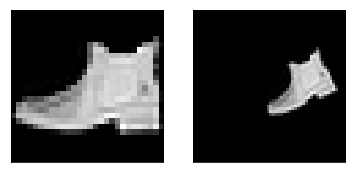

In [5]:
pt,idx = plot_ovt(DL,cmap='gray')

In [6]:
G_builder = GDenseNet(enc_layers=config.enc_layers,)
E_builder = EDenseNet(enc_layers=config.enc_layers,)

# mod_builder = TandemVAEBuilder(enc_layers=config.enc_layers,z_dim=config.z_dim)

In [7]:
trainer = Trainer(config,DL,Gbuilder=G_builder,Ebuilder=E_builder)
trainer.compile_model()
trainer.go(DL.sx_train,DL.y_train_oh,validation_split=0.05,verbose=0)

building encoder...
building decoder/generator...
Epoch:  0
{'val_recon_mse': 38.02742984008789, 'acc': 0.5777368420968976, 'val_loss': 4405.913652994792, 'recon_mse': 55.00048416458933, 'xentropy': 11.17562992256566, 'val_acc': 0.6610000020662944, 'val_xentropy': 8.663766649881998, 'loss': 5802.648842413651}
Epoch:  1
{'val_recon_mse': 33.47139572143555, 'acc': 0.700964912314164, 'val_loss': 3783.3961178385416, 'recon_mse': 34.5709503334447, 'xentropy': 7.743993248387387, 'val_acc': 0.7080000015894572, 'val_xentropy': 7.435146322886149, 'loss': 4012.6885547560305}
Epoch:  2
{'val_recon_mse': 30.26266921488444, 'acc': 0.7384912281036377, 'val_loss': 3881.4146653645835, 'recon_mse': 30.01933479898018, 'xentropy': 6.724447746076082, 'val_acc': 0.7063333374659221, 'val_xentropy': 7.6359840024312335, 'loss': 3486.999729355126}
Epoch:  3
{'val_recon_mse': 27.75384869893392, 'acc': 0.7581578948037666, 'val_loss': 3629.0004518229166, 'recon_mse': 27.842437723527876, 'xentropy': 6.138123694035

In [8]:
trainer.save_model()

In [9]:
hist_df = pd.DataFrame.from_records(trainer.history.history)
hist_df.head()

,acc,loss,recon_mse,val_acc,val_loss,val_recon_mse,val_xentropy,xentropy
0,0.577737,5802.648842,55.000484,0.661000,4405.913653,38.027430,8.663767,11.175630
1,0.700965,4012.688555,34.570950,0.708000,3783.396118,33.471396,7.435146,7.743993
2,0.738491,3486.999729,30.019335,0.706333,3881.414665,30.262669,7.635984,6.724448
3,0.758158,3181.865233,27.842438,0.733667,3629.000452,27.753849,7.136478,6.138124
4,0.779579,2890.814870,26.297225,0.731000,3687.129003,26.190177,7.253326,5.571797


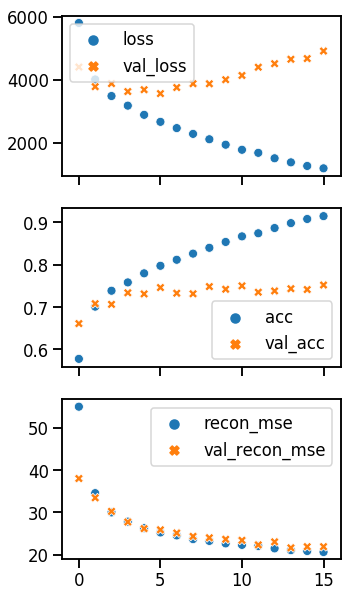

In [10]:
sns.set_context('talk')
fig,axs = plt.subplots(nrows=3,sharex=True,figsize=(5,10))
for metric_name,ax in zip(['loss','acc','recon_mse'],axs):
    sns.scatterplot(data=hist_df[[metric_name,'val_'+metric_name]],ax=ax)

In [11]:
trainer.G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2000)              42000     
_________________________________________________________________
dense_4 (Dense)              (None, 3000)              6003000   
_________________________________________________________________
reconstruction (Dense)       (None, 3136)              9411136   
Total params: 15,456,136
Trainable params: 15,456,136
Non-trainable params: 0
_________________________________________________________________


In [12]:
from keras.models import Model
from keras.layers import Input

In [13]:
z_encoder = Model(trainer.E.input,trainer.z_lat)
classifier = Model(trainer.E.input,trainer.y_lat)
generator = trainer.G
# decoder_inp = Input(shape=(config.y_dim+config.z_dim,))
# dec_layers = trainer.model.layers[-3:]
# _gen_x = dec_layers[0](decoder_inp)
# _gen_x = dec_layers[1](_gen_x)
# _gen_x = dec_layers[2](_gen_x)
# generator = Model(decoder_inp,_gen_x)

In [14]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2000)              42000     
_________________________________________________________________
dense_4 (Dense)              (None, 3000)              6003000   
_________________________________________________________________
reconstruction (Dense)       (None, 3136)              9411136   
Total params: 15,456,136
Trainable params: 15,456,136
Non-trainable params: 0
_________________________________________________________________


In [15]:
classifier.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
classifier.evaluate(DL.sx_test,DL.y_test_oh,batch_size=config.batch_size)

10000/10000 [==============================] - 0s 24us/step


[0.7354106204032897, 0.7347000004768371]

In [16]:
z_enc = z_encoder.predict(DL.sx_test,batch_size=config.batch_size)
y_class = classifier.predict(DL.sx_test,batch_size=config.batch_size)

In [17]:
z_enc.shape

(10000, 10)

In [18]:
_lat_vec = np.concatenate([y_class,z_enc],axis=1)
_lat_vec.shape

(10000, 20)

In [19]:
regen = generator.predict(_lat_vec,batch_size=config.batch_size)

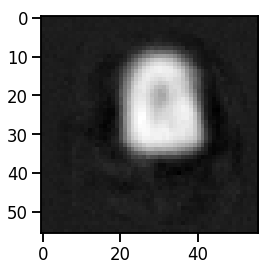

In [20]:
rand_im = np.random.randint(0,10000)
plt.imshow(regen[rand_im].reshape(56,56),cmap='gray')

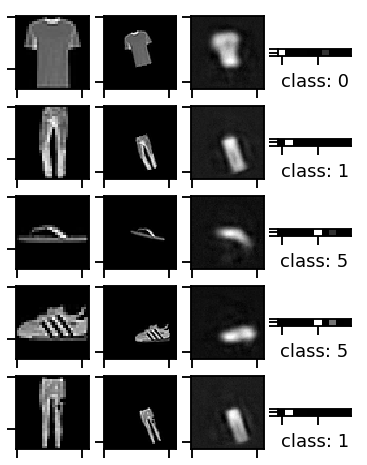

In [21]:
enc_dec_samples(DL.x_test,DL.sx_test,z_enc,y_class,generator)

In [22]:
from src.metrics import var_expl
dxs = DL.dx[1]-14
dys = DL.dy[1]-14
dtheta = DL.dtheta[1]
fve_dx = var_expl(features=z_enc,cond=dxs,bins=21)
fve_dy = var_expl(features=z_enc,cond=dys,bins=21)
fve_dt = var_expl(features=z_enc,cond=dtheta,bins=21)

In [23]:
fve_dx_norm = (dxs.var()-fve_dx)/dxs.var()
fve_dy_norm = (dys.var()-fve_dy)/dys.var()
fve_dth_norm = (dtheta.var()-fve_dt)/dtheta.var()

In [24]:
import seaborn as sns
sns.set_context('talk')

In [25]:
fve_dx_norm.shape

(21, 10)

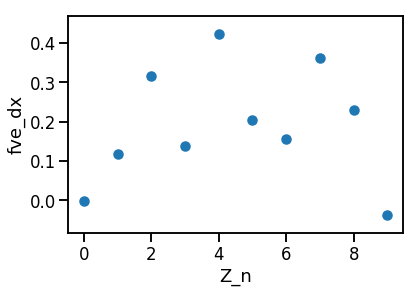

In [26]:
plt.scatter(np.arange(config.z_dim),fve_dx_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dx')
# plt.ylim(-0.125,0.25)
zdx = np.argmax(fve_dx_norm.mean(axis=0))

In [27]:
fve_dy_norm.mean(axis=0)

array([ 0.02434353,  0.63119368,  0.08351221, -0.02040955,  0.10655508,
        0.16340479, -0.0488961 ,  0.28670992,  0.02587938,  0.13265157])

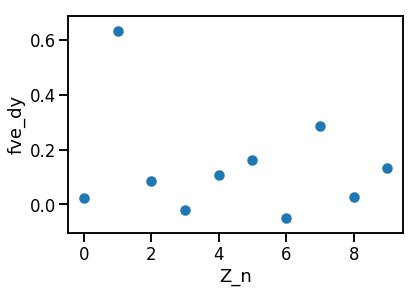

In [28]:
plt.scatter(np.arange(config.z_dim),fve_dy_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dy')
# plt.ylim(-0.125,0.25)
zdy = np.argmax(fve_dy_norm.mean(axis=0))

5

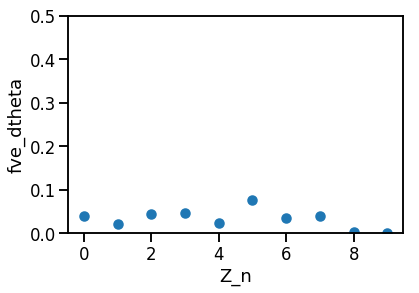

In [29]:
plt.scatter(np.arange(config.z_dim),fve_dth_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dtheta')
plt.ylim(0.0,0.5)
np.argmax(fve_dth_norm.mean(axis=0))

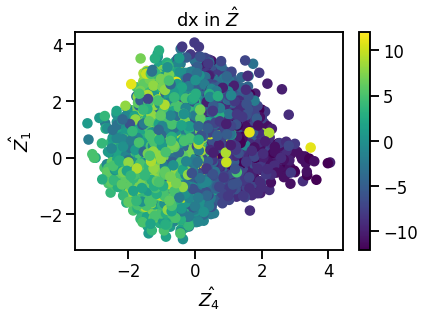

In [30]:
from src.plot import Z_color_scatter
Z_color_scatter(z_enc,[zdx,zdy],dxs)

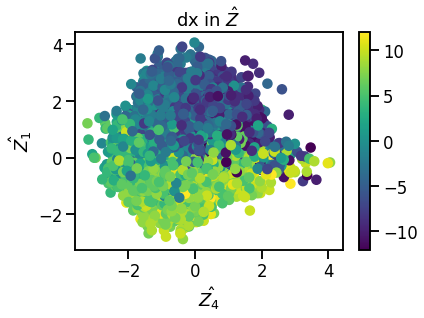

In [31]:
Z_color_scatter(z_enc,[zdx,zdy],dys)

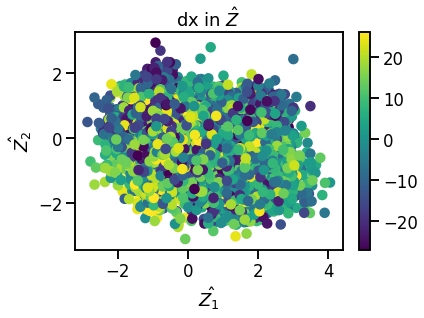

In [32]:
Z_color_scatter(z_enc,[1,2],dtheta)